In [1]:
import random
import tensorflow as tf
import numpy as np
from typing import List, Tuple
from skimage.draw import disk, rectangle, rectangle_perimeter
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
#pip install scikit-image

## Функция для генерации изображений

In [2]:
def gen(stop = 1):
  image_size = (224, 224)                                                         # высота, ширина
  i = 0
  while i < stop:
   
    im = np.ones((image_size[0],image_size[1], 3))                                # генерируем фон белого цвета
    im[:,:,0], im[:,:,1], im[:,:,2] = np.random.rand(3)                           # меняем цвет на рандомный

    figure_type = random.choice(['disk', 'rectangle'])                            # выбираем тип фигуры, цвет
    
    coords_centr = [random.uniform(0, 1), random.uniform(0, 1)]                   # Выбираем позицию центра 0-1-верх/низ, 0-1 - лево/право
  
    if figure_type == 'disk':                                                     # если фигура круг     
      radius = random.uniform(0.05, 0.10)                                         # задаём радиус
      
      bounding_top = max(coords_centr[0] - radius, 0)                             # задаём ограничения c 4х сторон
      bounding_left = max(coords_centr[1] - radius, 0)
      bounding_bottom = min(coords_centr[0] + radius, 1)
      bounding_right = min(coords_centr[1] + radius, 1)

      rr, cc = disk((coords_centr[0] * image_size[0], coords_centr[1] * image_size[1]), radius * min(image_size), shape=image_size)       # получаем координаты пикселей круга

      figure_type = 0.0                                                           # тип фигуры 0

   
    if figure_type == 'rectangle':                                                # если фигура прямоугольника
      rectangle_size  = [random.uniform(0.05, 0.20), random.uniform(0.05, 0.20)]  # [высота, ширина]
      bounding_top    = max(coords_centr[0] - rectangle_size[0] / 2, 0)           # задаём ограничения c 4х сторон
      bounding_left   = max(coords_centr[1] - rectangle_size[1] / 2, 0)
      bounding_bottom = min(coords_centr[0] + rectangle_size[0] / 2, 1)
      bounding_right  = min(coords_centr[1] + rectangle_size[1] / 2, 1)

      start = [round(bounding_top * image_size[0]), round(bounding_left * image_size[1])]                                           # промежуточная переменная, координаты верхнего левого угла прямоугольника
      extent = [round((bounding_bottom - bounding_top) * image_size[0]), round((bounding_right - bounding_left) * image_size[1])]   # промежуточная переменная, размер прямоугольника

      rr, cc = rectangle(start , extent=extent, shape=image_size)                                                                   # # получаем координаты пикселей прямоугольника

      figure_type = 1.0                                                                                                             # тип фигуры 1

    im[rr,cc,0], im[rr,cc,1], im[rr,cc,2] = np.random.rand(3)                         # отрисовываем фигуру рандгомным цветом


    # Выделяем рамкой объект 
    start = (bounding_top * image_size[0], bounding_left * image_size[1])             # промежуточная переменная, координаты верхнего левого угла рамки
    end =   (bounding_bottom * image_size[0], bounding_right * image_size[1])         # промежуточная переменная, размер рамки
    rr, cc = rectangle_perimeter(start, end=end, shape=image_size)                    # получаем координаты пикселей рамки

#    im[rr,cc,0], im[rr,cc,1], im[rr,cc,2] = (0, 0, 0)                                 # отрисовываем рамку

  
    yield im, np.array([figure_type,  bounding_top, bounding_left, bounding_bottom, bounding_right])

    i += 1


## Генератор изображений

In [3]:
dataset = tf.data.Dataset.from_generator(                                           # формируем датасет генератор 
     gen,
     args = [1],
     output_signature=(
         tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None),
         tf.TensorSpec(shape=(5), dtype=tf.float64, name=None))                     
)

In [4]:
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)                            # может так будет быстрее работать

## печать изображений для проверки
Ограничивающие рамки убрал, чтобы подавать в модель изображений без рамок

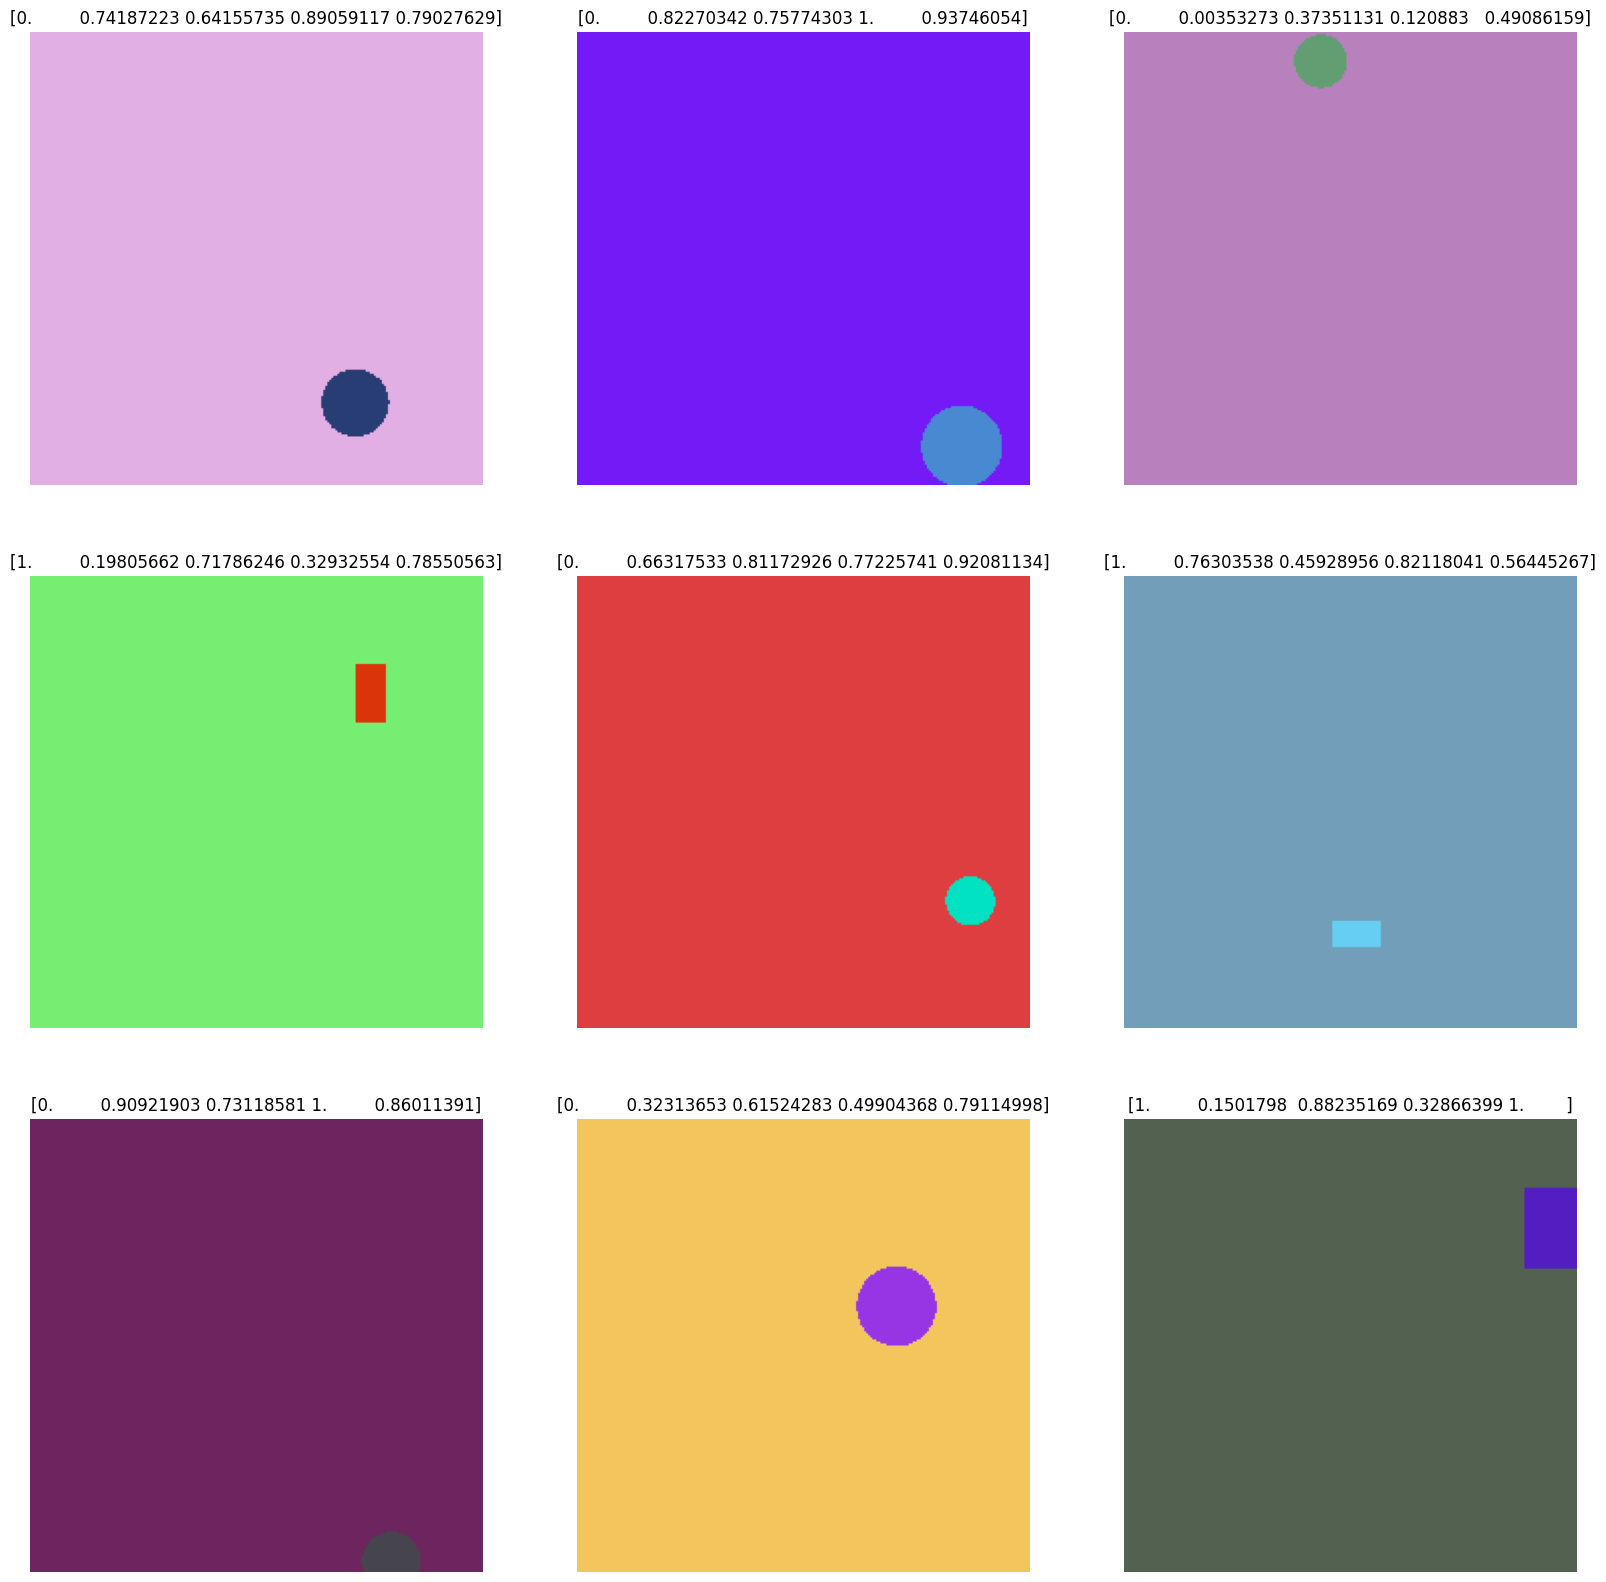

In [6]:
line = 3
column = 3

fig, axs = plt.subplots(line, column, figsize = (20, 20))

im = []
lable = []

for ds in dataset.repeat().take(line * column):
  im.append(ds[0])
  lable.append(ds[1])

im = np.array(im)
lable = np.array(lable)

i = 0

for l in range(line):
  for c in range(column):

    title = str(lable[i])
    axs[l][c].axis('off')
    axs[l][c].imshow(im[i])
    axs[l][c].set_title(title)

    i += 1

## Загрузка vgg16 ранее обученой на данных изображениях

In [7]:
model = keras.models.load_model('vgg16')

## эксперементы с заморозкой слоёв и обextybtv

In [ ]:
#model.layers[-1].trainable = True
#model.layers[-2].trainable = True
#model.layers[-4].layers[-7].trainable = False

In [ ]:
#model.layers[-4].layers

In [ ]:
# model.trainable_weights

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
             loss="binary_crossentropy",
#             metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()]
             metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [34]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="mymodel_{epoch}", save_best_only=True, monitor="loss", verbose=1)]

In [ ]:
model.fit(dataset.repeat().batch(2).take(100), epochs=5, verbose=1, callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.4019 - mean_squared_error: 0.0020
Epoch 1: loss did not improve from 0.38370
100/100 [==============================] - 125s 1s/step - loss: 0.4019 - mean_squared_error: 0.0020
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.4057 - mean_squared_error: 0.0014
Epoch 2: loss did not improve from 0.38370
100/100 [==============================] - 124s 1s/step - loss: 0.4057 - mean_squared_error: 0.0014
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.4064 - mean_squared_error: 0.0029
Epoch 3: loss did not improve from 0.38370
100/100 [==============================] - 126s 1s/step - loss: 0.4064 - mean_squared_error: 0.0029
Epoch 4/5
 40/100 [===========>..................] - ETA: 1:15 - loss: 0.4206 - mean_squared_error: 9.6043e-04

In [ ]:
#model.save('vgg16')

## Визуальная проверка результата

1/1 [==============================] - 1s 796ms/step


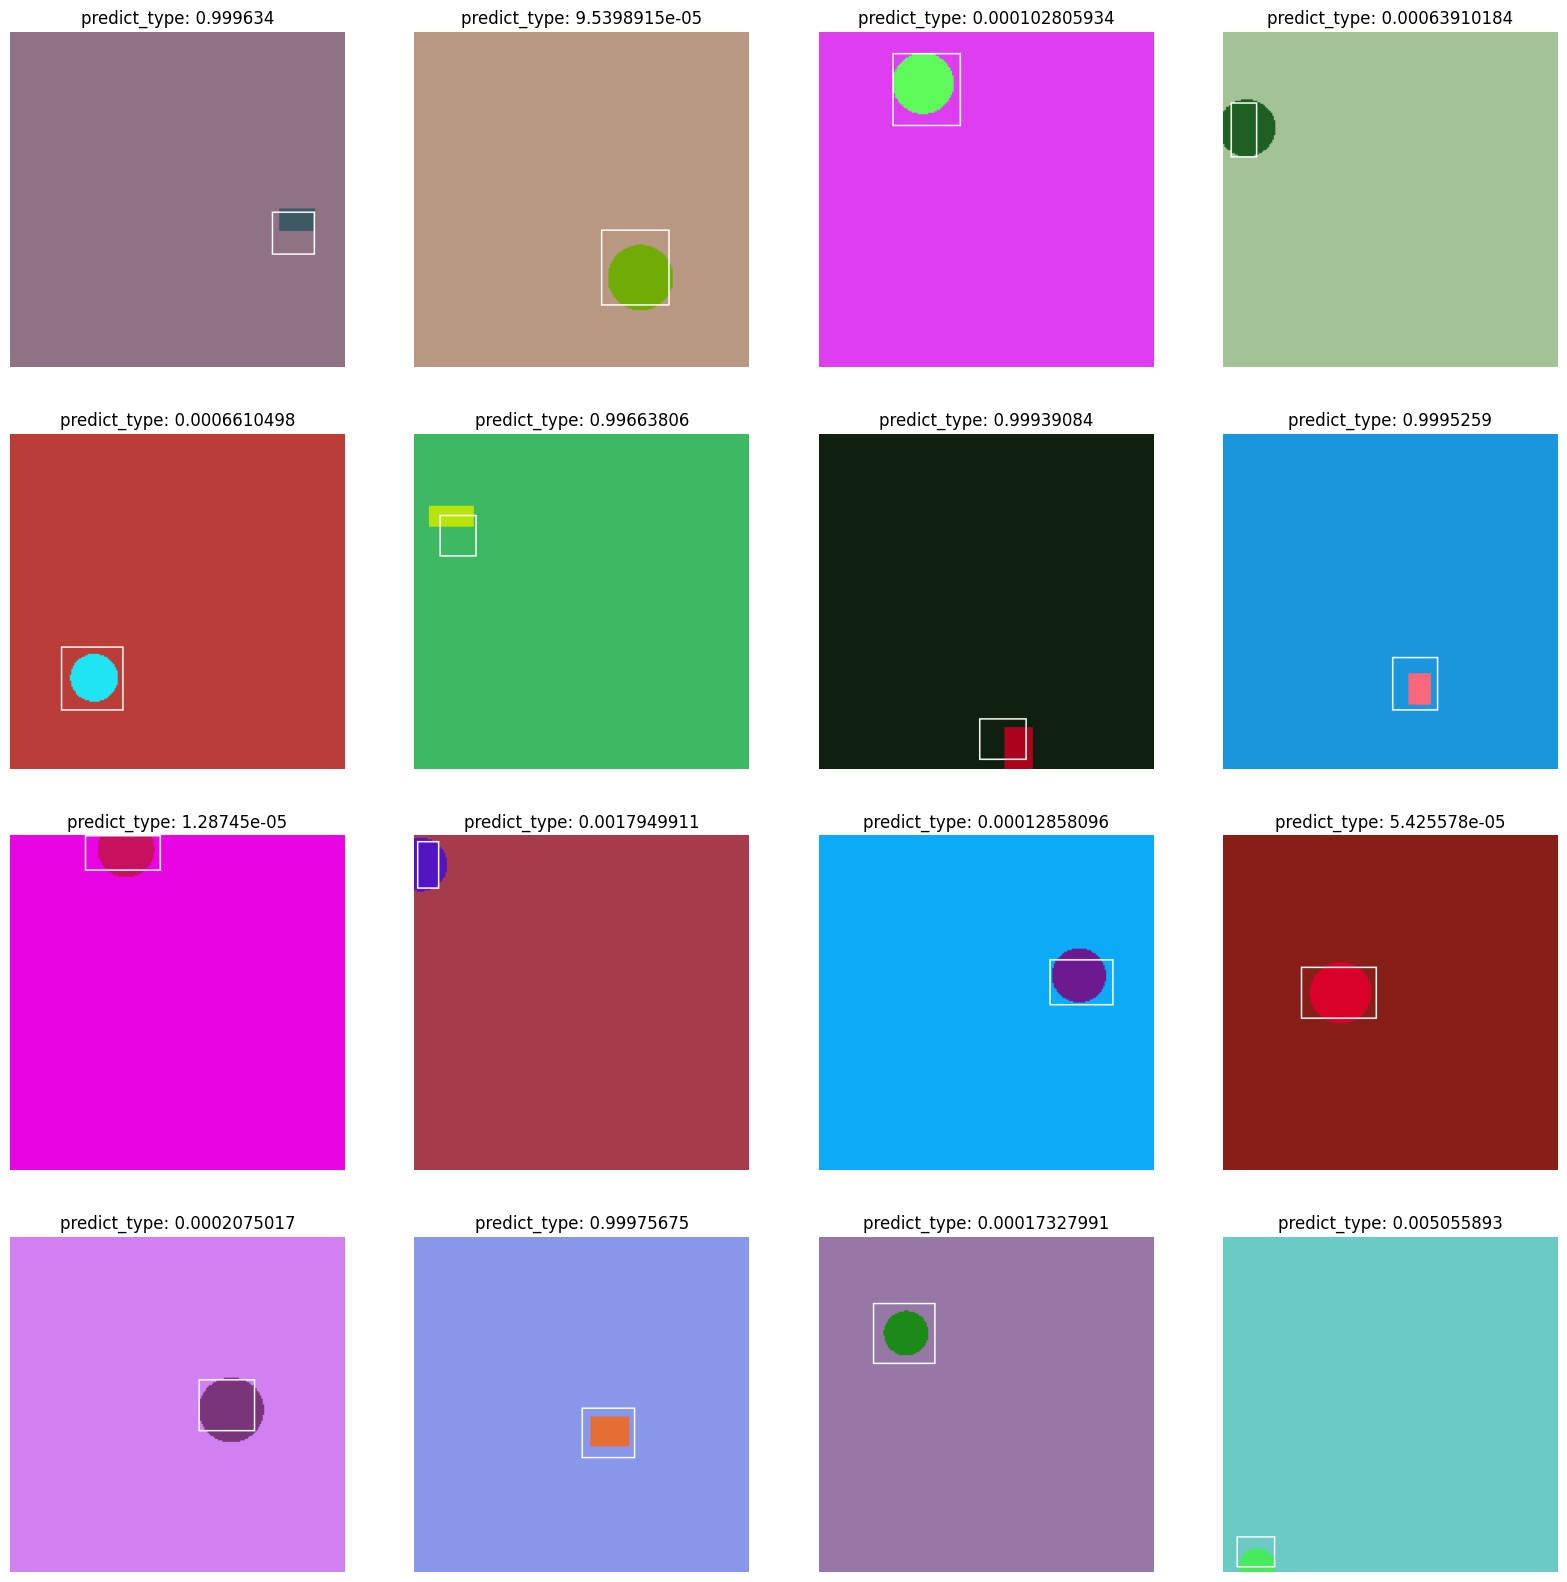

In [42]:
line = 4    #количество строк
column = 4  # количество столбцов

fig, axs = plt.subplots(line, column, figsize = (20, 20))  # для печати нескольких изображений

im_list = []                                               # лист для изображений 
lable_list = []                                            # лист для подписей

for ds in dataset.repeat().take(line * column):            # перебираем изображения
    im = np.array(ds[0])                                   # картинку из tf в numpy

    predict = model.predict(np.expand_dims(im, axis=0))    # предсказание 
    
    start = (predict[0][1] * 224, predict[0][2] * 224)
    end =   (predict[0][3] * 224, predict[0][4] * 224)
    rr, cc = rectangle_perimeter(start, end=end, shape=(224, 224))

    im[rr,cc,0], im[rr,cc,1], im[rr,cc,2] = (1, 1, 1)
    
    lable_list.append(predict[0][0])
    im_list.append(np.array(im))
    
im_list = np.array(im_list)
lable_list = np.array(lable_list)

i = 0

for l in range(line):
    for c in range(column):
        title = str(lable_list[i])
        axs[l][c].axis('off')
        axs[l][c].imshow(im_list[i])
        axs[l][c].set_title('predict_type: ' + title)

        i += 1

In [2]:
pip freeze > requirements.txt

absl-py==1.4.0
anyio==3.6.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asttokens==2.2.1
astunparse==1.6.3
attrs==23.1.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==5.3.0
certifi==2023.5.7
cffi==1.15.1
charset-normalizer==3.1.0
colorama==0.4.6
comm==0.1.3
contourpy==1.0.7
cycler==0.11.0
debugpy==1.6.7
decorator==5.1.1
defusedxml==0.7.1
executing==1.2.0
fastjsonschema==2.17.1
flatbuffers==23.5.9
fonttools==4.39.4
fqdn==1.5.1
gast==0.4.0
google-auth==2.18.1
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
grpcio==1.54.2
h5py==3.8.0
idna==3.4
imageio==2.28.1
ipykernel==6.23.1
ipython==8.13.2
ipython-genutils==0.2.0
isoduration==20.11.0
jax==0.4.10
jedi==0.18.2
Jinja2==3.1.2
jsonpointer==2.3
jsonschema==4.17.3
jupyter-events==0.6.3
jupyter_client==8.2.0
jupyter_core==5.3.0
jupyter_server==2.5.0
jupyter_server_terminals==0.4.4
jupyterlab-pygments==0.2.2
keras==2.12.0
kiwisolver==1.4.4
lazy_loader==0.2
libclang==16.0.0
Markdown==3.4.3
MarkupSafe==2.1.2
m